In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import gspread
import matplotlib.pyplot as plt

In [2]:
exps = ['0928_jiuhai_seed-01']

datasets = ['ogb-molpcba', 'ogb-molhiv', 'ogbg-ppa', 'UPFD', 'SBM-Isolation', 'SBM-Environment', 'RotatedMNIST', 'ColoredMNIST']
algorithms = ['ERM', 'groupDRO', 'IRM', 'deepCORAL', 'DANN', 'DANN-G', 'MLDG', 'FLAG']
models = ['gin', 'mlp', 'gin_10_layers', 'gcn', 'gin_virtual', 'transformer', 'cheb', '3wlgnn']


base_model = {
    'ogb-molpcba': 'gin_virtual', 
    'ogb-molhiv': 'gin_virtual',
    'ogbg-ppa': 'gin_virtual',
    'UPFD': 'cheb',
    'SBM-Isolation': 'cheb',
    'SBM-Environment': 'gin_10_layers',
    'RotatedMNIST': 'cheb',
    'ColoredMNIST': 'cheb',
}


def parse_performance(d, a, m, exps, assert_length=True):
    epoches_coeff = 1
    performances = []
    m = base_model[d]
    for exp in exps:
        seeds = [0, 1]
        for seed in seeds:
            test_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_test_eval.csv', sep=',')
            test_eval = test_eval.dropna(axis=0)
            test_eval = test_eval.iloc[:,1].to_numpy()
            val_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_val_eval.csv', sep=',')
            val_eval = val_eval.dropna(axis=0)
            val_eval = val_eval.iloc[:,1].to_numpy()
            train_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_train_eval.csv', sep=',')
            train_eval = train_eval.dropna(axis=0)
            train_eval = train_eval.iloc[:,1].to_numpy()
            nepoch = max([len(train_eval), len(val_eval), len(test_eval)])
            performances.append((train_eval[:nepoch], val_eval[:nepoch], test_eval[:nepoch]))
    return performances
    
def filter_test_performance(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append(test_eval[np.argmax(val_eval)])
    return results


def filter_performance_gaps(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append((train_eval[np.argmax(val_eval)]-test_eval[np.argmax(val_eval)]))
    return results

def filter_num_epoches(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append(len(train_eval))
    return results

def filter_uncertainty(results):
    results = np.array(results)
    if len(results) == 1:
        return f'{results[0]:.3f}±?'
    return f'{np.mean(results):.3f}±{np.std(results):.3f}'


def filter_plot(performances):
    results = []
    plt.figure(figsize=(10, 5))
    for per in performances:
        train_eval, val_eval, test_eval = per
        plt.plot(train_eval, 'r')
        plt.plot(val_eval, 'g')
        plt.plot(test_eval, 'b')
    plt.show()
    return results


def parse(mode, **kwargs):
    try:
        if mode == 'test_performance':
            return filter_uncertainty(filter_test_performance(parse_performance(**kwargs)))
        if mode == 'performance_gap':
            return filter_uncertainty(filter_performance_gaps(parse_performance(**kwargs)))
        if mode == 'num_epoches':
            return filter_uncertainty(filter_num_epoches(parse_performance(**kwargs)))
        if mode == 'convergence_plot':
            return filter_plot(parse_performance(**kwargs))
        else:
            raise NotImplementError
    except OSError as e:
        return 'fnf'
    except pd.errors.EmptyDataError as e:
        return 'err'

In [3]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        table_dataset.append(parse('test_performance', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=algorithms)

print(table)
#print(table.to_csv(index=False, header=False))

                         ERM     groupDRO          IRM    deepCORAL         DANN       DANN-G         MLDG         FLAG
ogb-molpcba      0.177±0.004  0.150±0.003  0.051±0.003  0.071±0.002          err          err          err  0.181±0.002
ogb-molhiv       0.773±0.029  0.771±0.000  0.726±0.005  0.687±0.017          err          err  0.700±0.013  0.783±0.012
ogbg-ppa         0.578±0.000  0.422±0.036  0.219±0.007  0.506±0.002          err          err  0.094±0.007  0.588±0.037
UPFD             0.829±0.000  0.824±0.004  0.828±0.001  0.825±0.003  0.765±0.003  0.760±0.004  0.832±0.005  0.823±0.001
SBM-Isolation    0.698±0.000  0.691±0.013  0.693±0.004  0.684±0.018  0.691±0.004  0.653±0.002  0.709±0.001  0.700±0.005
SBM-Environment  0.846±0.011  0.836±0.001  0.838±0.005  0.863±0.011  0.799±0.052  0.830±0.007  0.803±0.001  0.834±0.015
RotatedMNIST     0.552±0.001  0.553±0.000  0.547±0.000  0.547±0.000  0.543±0.000  0.538±0.005  0.553±0.001  0.553±0.008
ColoredMNIST     0.121±0.000  0.116±0.00

In [4]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        table_dataset.append(parse('performance_gap', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=algorithms)

print(table)
#print(table.to_csv(index=False, header=False))

                         ERM     groupDRO           IRM     deepCORAL          DANN        DANN-G          MLDG         FLAG
ogb-molpcba      0.097±0.048  0.175±0.045  -0.018±0.002  -0.023±0.003           err           err           err  0.197±0.037
ogb-molhiv       0.134±0.031  0.002±0.014  -0.142±0.038  -0.019±0.022           err           err  -0.198±0.038  0.081±0.046
ogbg-ppa         0.178±0.039  0.066±0.033  -0.046±0.015   0.109±0.007           err           err   0.005±0.003  0.060±0.035
UPFD             0.050±0.003  0.058±0.005   0.053±0.006   0.031±0.010  -0.018±0.022  -0.089±0.016   0.045±0.009  0.058±0.003
SBM-Isolation    0.018±0.010  0.015±0.013   0.027±0.002   0.032±0.003   0.031±0.004   0.044±0.002   0.029±0.004  0.044±0.011
SBM-Environment  0.039±0.013  0.057±0.008   0.073±0.021   0.042±0.003   0.037±0.017   0.025±0.007   0.098±0.007  0.007±0.017
RotatedMNIST     0.051±0.002  0.071±0.003   0.056±0.007   0.068±0.003   0.041±0.002   0.042±0.006   0.035±0.011  0.080±0.018


In [5]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        table_dataset.append(parse('num_epoches', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=algorithms)

print(table)
#print(table.to_csv(index=False, header=False))

                           ERM        groupDRO             IRM      deepCORAL           DANN         DANN-G           MLDG            FLAG
ogb-molpcba      88.500±12.500  101.500±15.500    33.500±5.500  61.500±10.500            err            err            err   93.000±10.000
ogb-molhiv        69.000±2.000    24.000±1.000   44.500±27.500   44.000±3.000            err            err   24.000±6.000    46.000±8.000
ogbg-ppa         88.500±13.500   73.500±10.500   73.500±16.500  129.000±7.000            err            err   22.000±1.000   69.000±13.000
UPFD              44.000±3.000    44.500±4.500    70.500±6.500   46.500±3.500   19.500±1.500   17.500±0.500   63.000±1.000    31.000±2.000
SBM-Isolation     78.000±4.000    85.000±1.000    85.500±7.500  79.500±25.500  140.500±0.500   90.000±0.000   85.000±5.000  100.500±23.500
SBM-Environment   78.500±1.500    88.500±9.500  108.500±17.500  76.000±13.000  97.500±56.500  87.500±17.500   78.500±4.500   47.000±21.000
RotatedMNIST     110.500±1.

ogb-molpcba
ogb-molhiv


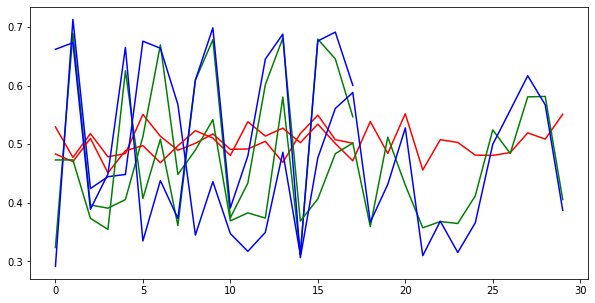

ogbg-ppa


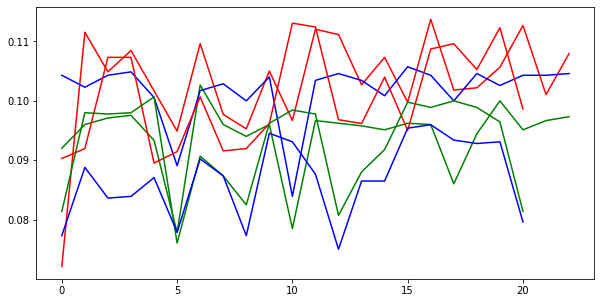

UPFD


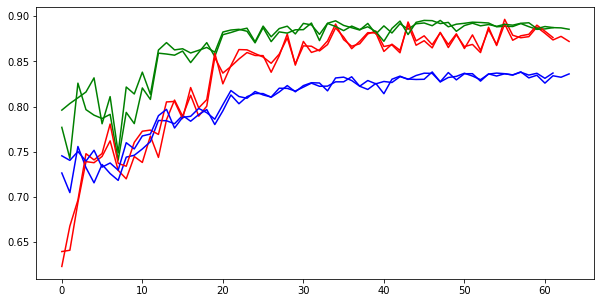

SBM-Isolation


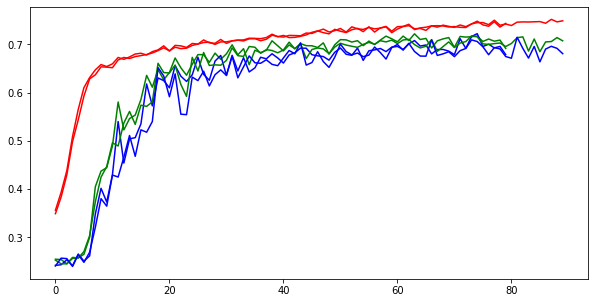

SBM-Environment


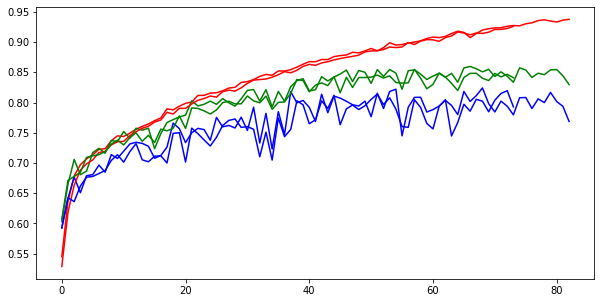

RotatedMNIST


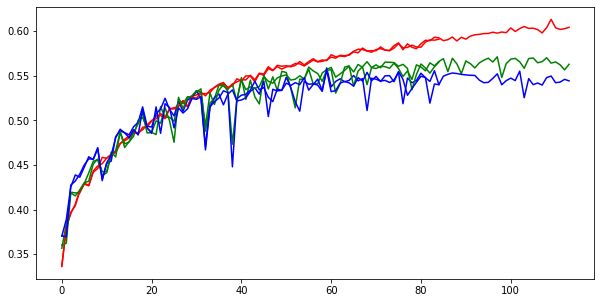

ColoredMNIST


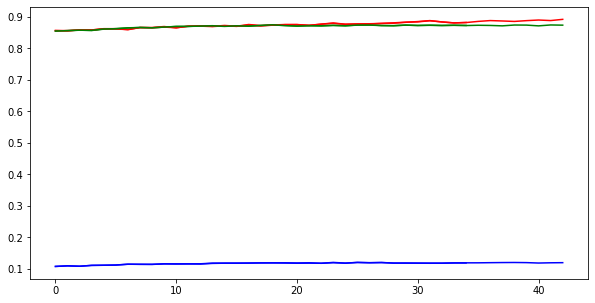

In [6]:
for d in datasets:
    print(d)
    parse('convergence_plot', d=d, a='MLDG', m='gin', exps=exps)